# Visualizing BCR data
![dandelion_logo](img/dandelion_logo_illustration.png)

## Integration with `scanpy`
Now that we have both 1) a pre-processed BCR data in `Dandelion` object and 2) matching `AnnData` object, we can start finding clones and *'integrate'* the results. All the BCR analyses files can be saved as *.tsv* format so that it can be used in other tools like *immcantation*, *immunoarch*, *vdjtools*, etc.

The results can also be ported into the `AnnData` object for access to more plotting functions provided through `scanpy`.

***Import modules***

In [1]:
import os
import pandas as pd
import dandelion as ddl
ddl.logging.print_header()

dandelion==0.0.29 pandas==1.1.4 numpy==1.19.4 matplotlib==3.3.3 networkx==2.5 scipy==1.5.3 skbio==0.5.6


In [2]:
# change directory to somewhere more workable
os.chdir(os.path.expanduser('/Users/kt16/Downloads/dandelion_tutorial/'))
# I'm importing scanpy here to make use of its logging module.
import scanpy as sc
sc.settings.verbosity = 3
import warnings
warnings.filterwarnings('ignore')
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.4 scipy==1.5.3 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 leidenalg==0.8.3


***Read in the previously saved files***

I will work with the same example from the previous notebook since I have the `AnnData` object saved and vdj table filtered.

In [3]:
adata = sc.read_h5ad('adata.h5ad')
adata

AnnData object with n_obs × n_vars = 16492 × 1497
    obs: 'sampleid', 'batch', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'is_doublet', 'filter_rna', 'has_bcr', 'filter_bcr_quality', 'filter_bcr_heavy', 'filter_bcr_light', 'bcr_QC_pass', 'filter_bcr', 'leiden'
    var: 'feature_types', 'genome', 'gene_ids-0', 'gene_ids-1', 'gene_ids-2', 'gene_ids-3', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'bcr_QC_pass_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [4]:
vdj = ddl.read_h5('dandelion_results.h5')
vdj

Dandelion class object with n_obs = 838 and n_contigs = 1700
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'c_call', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'v_call_genotyped', 'germline_alignment_d_mask', 'sample_id', 'c_sequence_alignment', 'c_germline_alignment', 'c_sequence_start',

### `tl.transfer`

To proceed, we first need to initialise the `AnnData` object with our network. This is done by using the tool function `tl.transfer`.

In [5]:
ddl.tl.transfer(adata, vdj) # this will include singletons. To show only expanded clones, specify expanded_only=True
adata

Transferring network
converting matrices
Updating anndata slots
 finished: updated `.obs` with `.metadata`
added to `.uns['neighbors']` and `.obsp`
   'distances', cluster-weighted adjacency matrix
   'connectivities', cluster-weighted adjacency matrix (0:00:18)


AnnData object with n_obs × n_vars = 16492 × 1497
    obs: 'sampleid', 'batch', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'is_doublet', 'filter_rna', 'has_bcr', 'filter_bcr_quality', 'filter_bcr_heavy', 'filter_bcr_light', 'bcr_QC_pass', 'filter_bcr', 'leiden', 'clone_id', 'clone_id_by_size', 'sample_id', 'locus_heavy', 'locus_light', 'productive_heavy', 'productive_light', 'v_call_genotyped_heavy', 'v_call_genotyped_light', 'j_call_heavy', 'j_call_light', 'c_call_heavy', 'c_call_light', 'umi_count_heavy_0', 'umi_count_light_0', 'umi_count_light_1', 'umi_count_light_2', 'junction_aa_heavy', 'junction_aa_light', 'status', 'productive', 'isotype', 'vdj_status_detail', 'vdj_status', 'changeo_clone_id'
    var: 'feature_types', 'genome', 'gene_ids-0', 'gene_ids-1', 'gene_ids-2', 'gene_ids-3', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'bcr_QC_pass_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap', 'rna

You can see that `AnnData` object now contains a couple more columns in the `.obs` slot, corresponding to the metadata that is returned after `tl.generate_network`, and newly populated `.obsm` and `.obsp` slots. The original RNA connectivities and distances are now added into the `.obsp` slot as well.

## Plotting in `scanpy`

### `pl.clone_network`

So now, basically we can plot in `scanpy` with their plotting modules. I've included a plotting function in ***dandelion***, `pl.clone_network`, which is really just a wrapper of their `pl.embedding` module.

... storing 'clone_id' as categorical
... storing 'sample_id' as categorical
... storing 'locus_heavy' as categorical
... storing 'locus_light' as categorical
... storing 'productive_heavy' as categorical
... storing 'productive_light' as categorical
... storing 'v_call_genotyped_heavy' as categorical
... storing 'v_call_genotyped_light' as categorical
... storing 'j_call_heavy' as categorical
... storing 'j_call_light' as categorical
... storing 'c_call_heavy' as categorical
... storing 'c_call_light' as categorical
... storing 'junction_aa_heavy' as categorical
... storing 'junction_aa_light' as categorical
... storing 'status' as categorical
... storing 'productive' as categorical
... storing 'isotype' as categorical
... storing 'vdj_status_detail' as categorical
... storing 'vdj_status' as categorical
... storing 'changeo_clone_id' as categorical


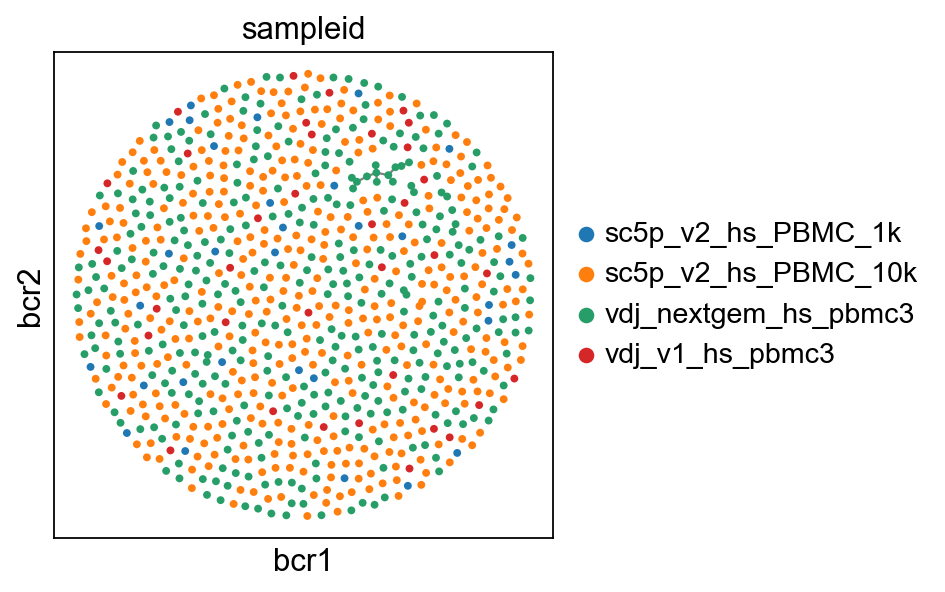

In [6]:
sc.set_figure_params(figsize = [4,4])
ddl.pl.clone_network(adata, 
                     color = ['sampleid'], 
                     edges_width = 1,
                     size = 50) 

### `tl.extract_edge_weights`

***dandelion*** provides an edge weight extractor tool `tl.extract_edge_weights` to retrieve the edge weights that can be used to specify the edge widths according to weight/distance.

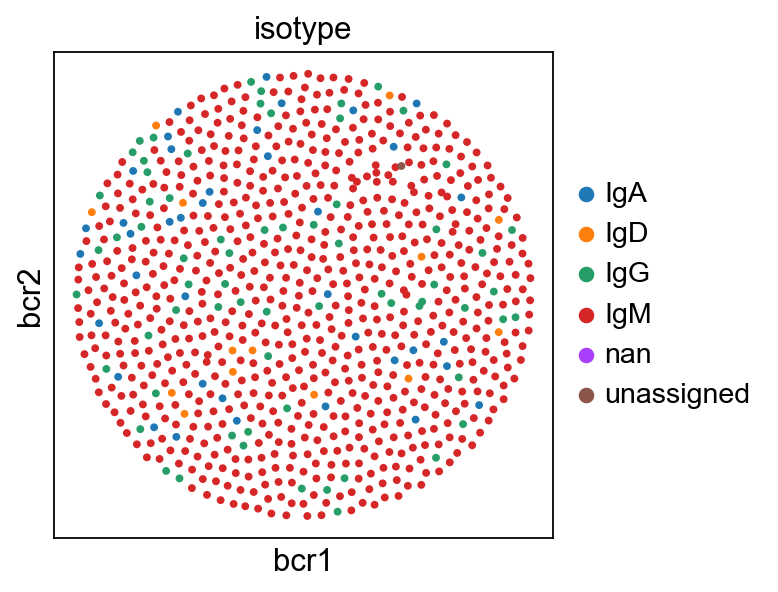

In [7]:
edgeweights = [1/(e+1) for e in ddl.tl.extract_edge_weights(vdj)] # add 1 to each edge weight (e) so that distance of 0 becomes the thickest edge
ddl.pl.clone_network(adata, 
                     color = ['isotype'], 
                     legend_fontoutline=3, 
                     edges_width = edgeweights,
                     size = 50) 

`unassigned` here means there is no isotype information i.e. no `c_call`, and `nan` means there's no BCR.

You can interact with `pl.clone_network` just as how you interact with the rest of the scatterplot modules in `scanpy`.

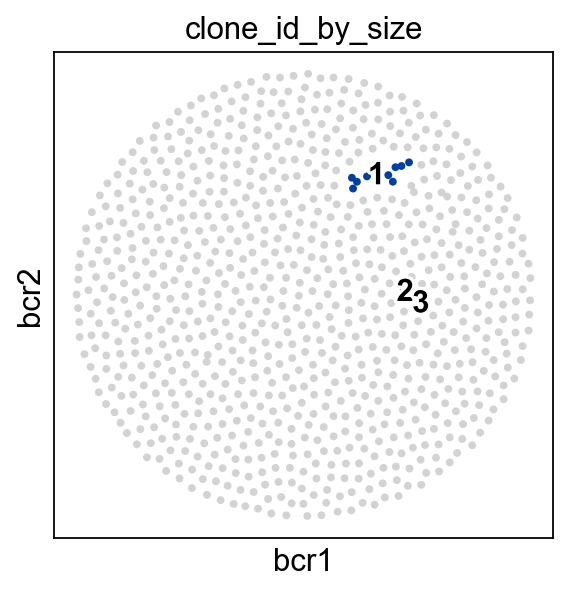

In [8]:
from scanpy.plotting.palettes import default_28, default_102
sc.set_figure_params(figsize = [4,4])
# plot the 3 largest clones by size
ddl.pl.clone_network(adata, color = ['clone_id_by_size'], groups = ['1', '2', '3'], ncols = 2, legend_loc = 'on data', legend_fontoutline=3, edges_width = edgeweights, size = 50, palette = default_28)

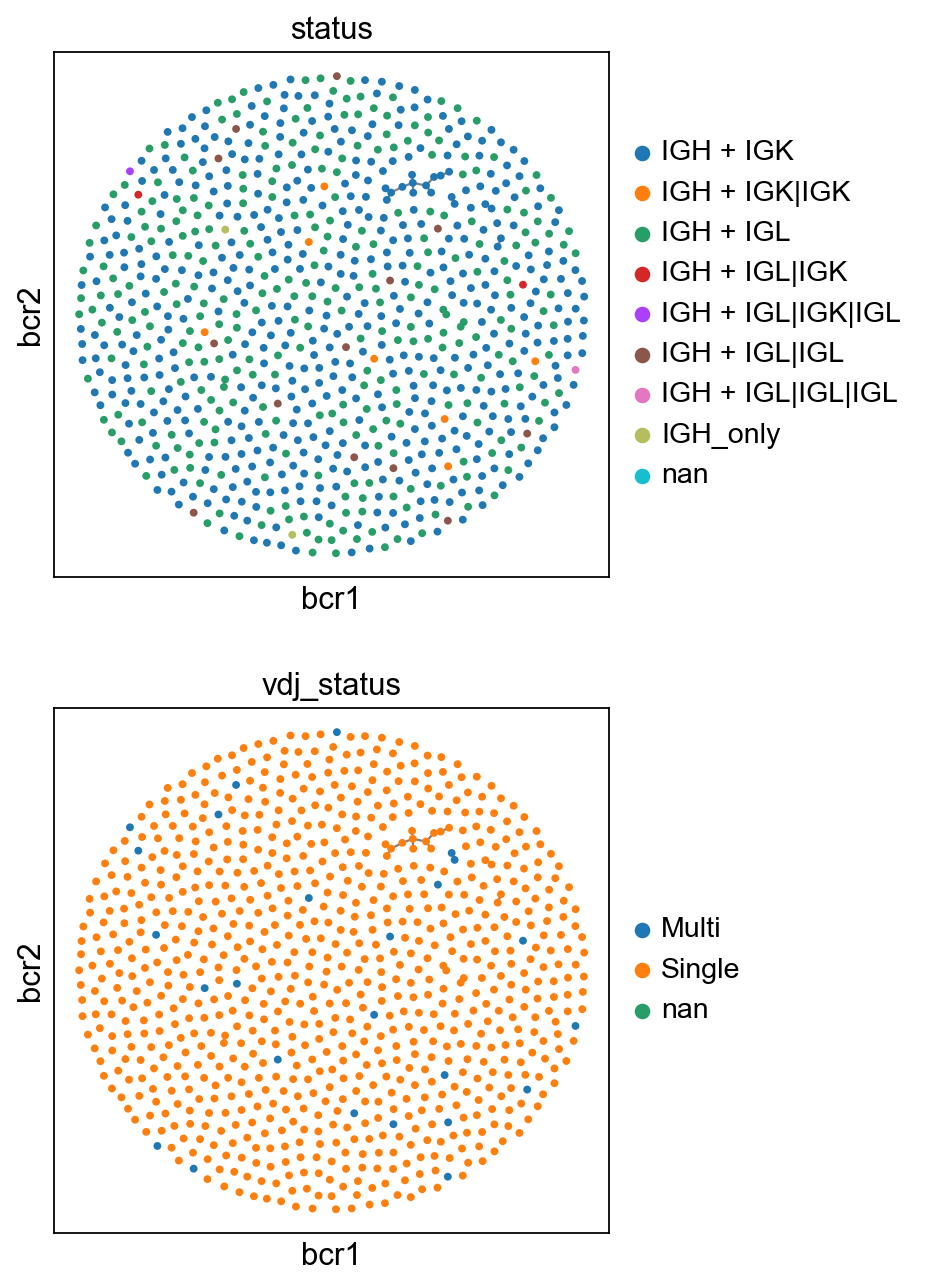

In [9]:
sc.set_figure_params(figsize = [4,4.5])
ddl.pl.clone_network(adata, color = ['status', 'vdj_status'], ncols = 1, legend_fontoutline=3, edges_width = 1, size = 50)

By specifying `expanded_only=True`, you will transfer the graph of only expanded clones (> 1 cell in a clone).

Transferring network
converting matrices
Updating anndata slots
 finished: updated `.obs` with `.metadata`
added to `.uns['neighbors']` and `.obsp`
   'distances', cluster-weighted adjacency matrix
   'connectivities', cluster-weighted adjacency matrix (0:00:18)


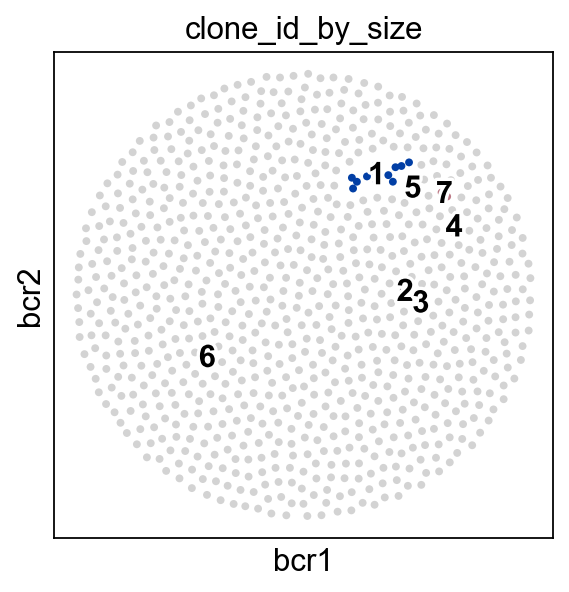

In [10]:
sc.set_figure_params(figsize = [4,4])
ddl.tl.transfer(adata, vdj)
edgeweights = [1/(e+1) for e in ddl.tl.extract_edge_weights(vdj)] # add 1 to each edge weight (e) so that distance of 0 becomes the thickest edge
ddl.pl.clone_network(adata, color = ['clone_id_by_size'], groups = ['1', '2', '3', '4', '5', '6', '7'], legend_loc = 'on data', legend_fontoutline=3, edges_width = edgeweights, size = 50)

In [11]:
adata.write('adata.h5ad', compression = 'gzip')

## Calculating size of clones

### `tl.clone_size`

Sometimes it's useful to evaluate the size of the clone. Here `tl.quantify_clone_size` does a simple calculation to enable that.

In [12]:
ddl.tl.clone_size(vdj)
ddl.tl.transfer(adata, vdj)

Quantifying clone sizes
 finished: Updated Dandelion object: 
   'metadata', cell-indexed clone table (0:00:00)
Transferring network
converting matrices
Updating anndata slots
 finished: updated `.obs` with `.metadata`
added to `.uns['neighbors']` and `.obsp`
   'distances', cluster-weighted adjacency matrix
   'connectivities', cluster-weighted adjacency matrix (0:00:19)


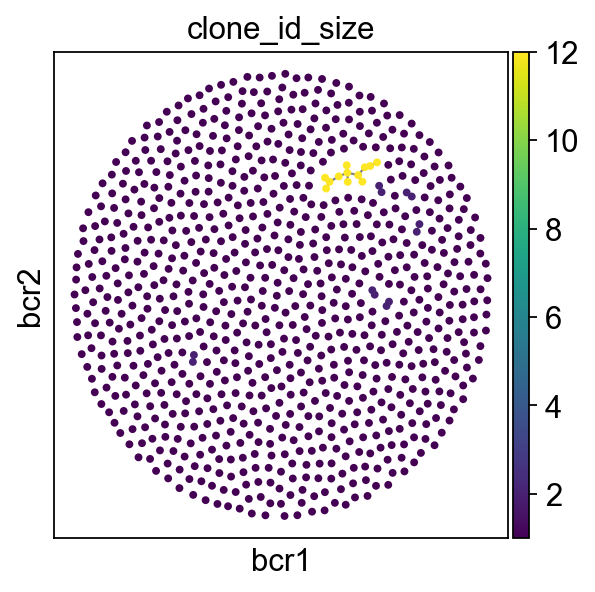

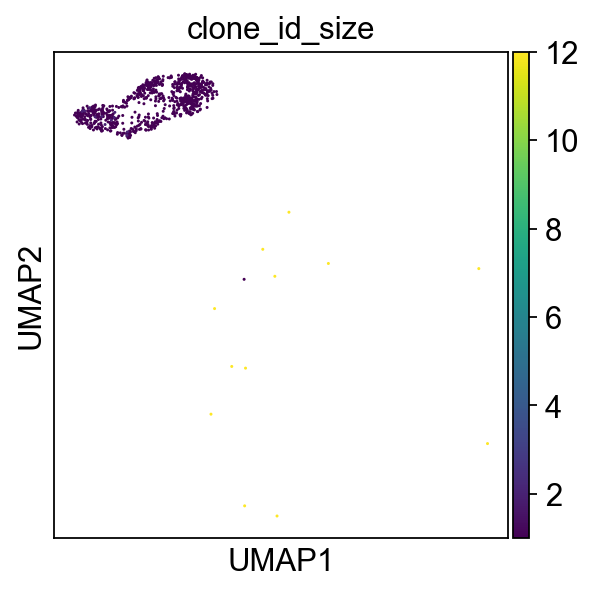

In [13]:
ddl.pl.clone_network(adata, color = ['clone_id_size'], legend_loc = 'none', legend_fontoutline=3, edges_width = 1, size = 50)
sc.pl.umap(adata, color = ['clone_id_size'])

You can also specify `max_size` to clip off the calculation at a fixed value.

In [14]:
ddl.tl.clone_size(vdj, max_size = 3)
ddl.tl.transfer(adata, vdj)

Quantifying clone sizes
 finished: Updated Dandelion object: 
   'metadata', cell-indexed clone table (0:00:00)
Transferring network
converting matrices
Updating anndata slots
 finished: updated `.obs` with `.metadata`
added to `.uns['neighbors']` and `.obsp`
   'distances', cluster-weighted adjacency matrix
   'connectivities', cluster-weighted adjacency matrix (0:00:17)


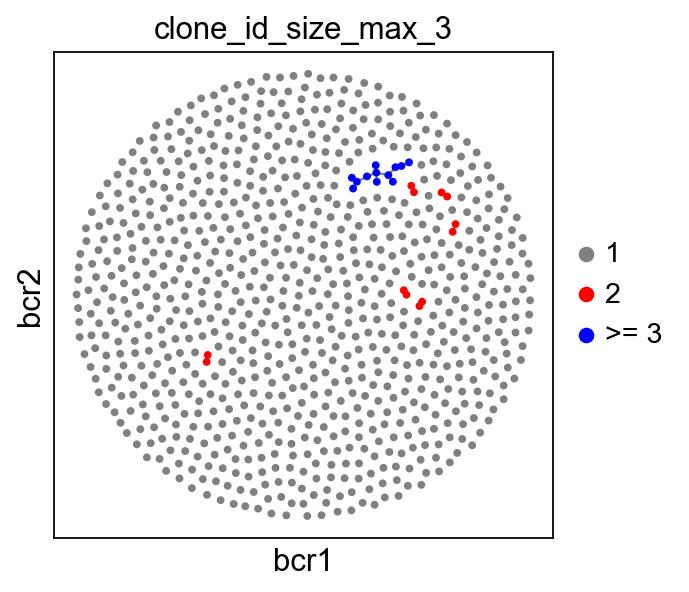

Trying to set attribute `.uns` of view, copying.


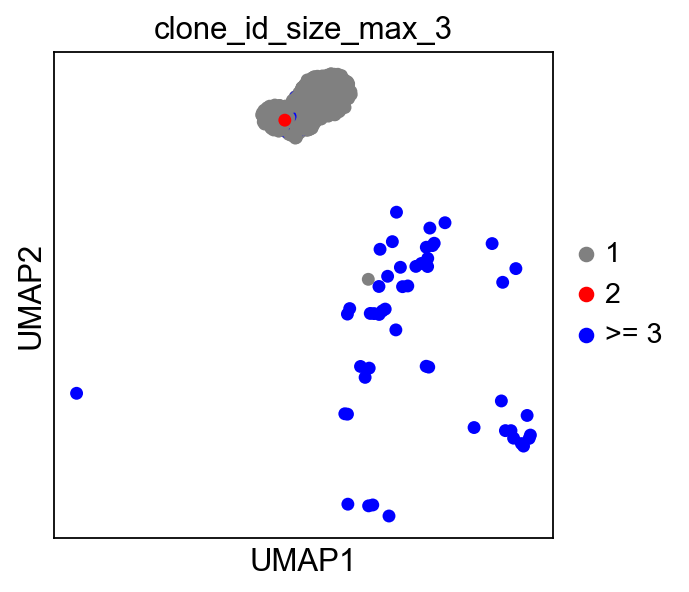

In [15]:
ddl.pl.clone_network(adata, color = ['clone_id_size_max_3'], ncols = 2, legend_fontoutline=3, edges_width = 1, palette = ['grey', 'red', 'blue', 'white'], size = 50)
sc.pl.umap(adata[adata.obs['has_bcr'] == 'True'], color = ['clone_id_size_max_3'], palette = ['grey', 'red', 'blue', 'white'])

## Additional plotting functions

### `pl.barplot`
`pl.barplot` is a generic barplot function that will plot items in the metadata slot as a bar plot. This function will also interact with `.obs` slot if a `scanpy` object is used in place of `Dandelion` object. However, if your `scanpy` object holds a lot of non-B cells, then the plotting will be just be saturated with nan values.

(<Figure size 1200x400 with 1 Axes>,
 <AxesSubplot:title={'center':'v call genotyped heavy usage'}, ylabel='proportion'>)

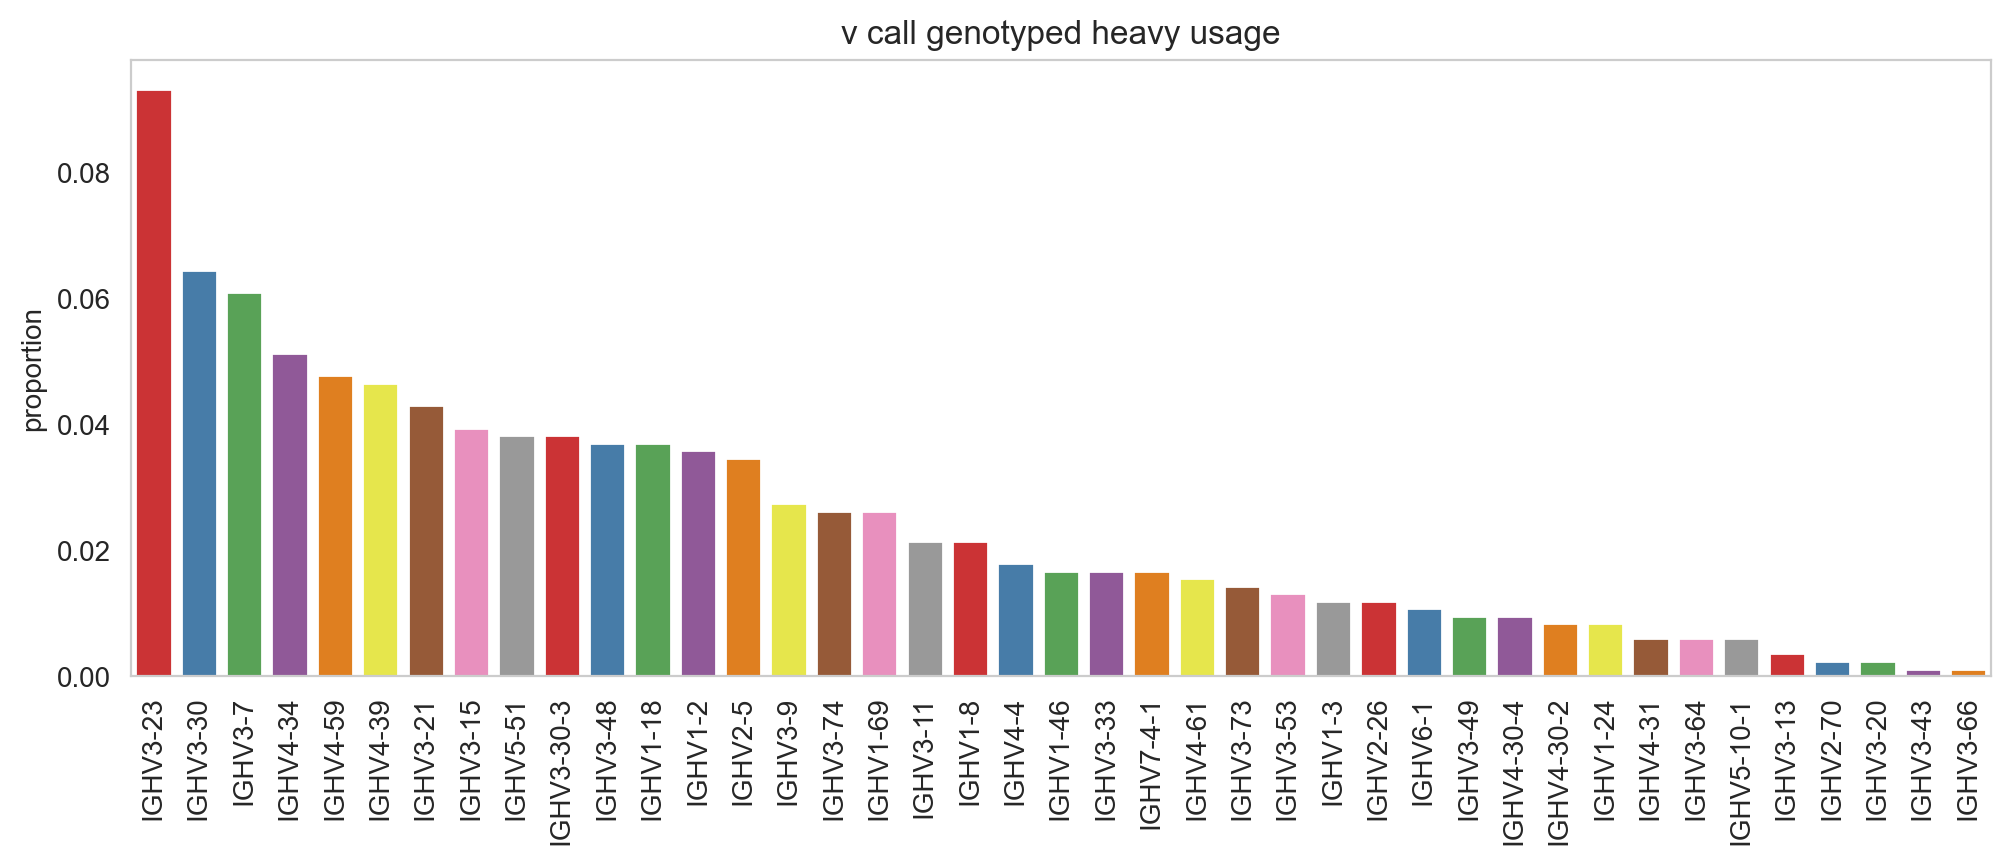

In [16]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
ddl.pl.barplot(vdj, variable = 'v_call_genotyped_heavy', figsize = (12, 4))

You can prevent it from sorting by specifying `sort_descending = None`. Colours can be changed with `palette` option.

(<Figure size 1200x400 with 1 Axes>,
 <AxesSubplot:title={'center':'v call genotyped heavy usage'}, ylabel='proportion'>)

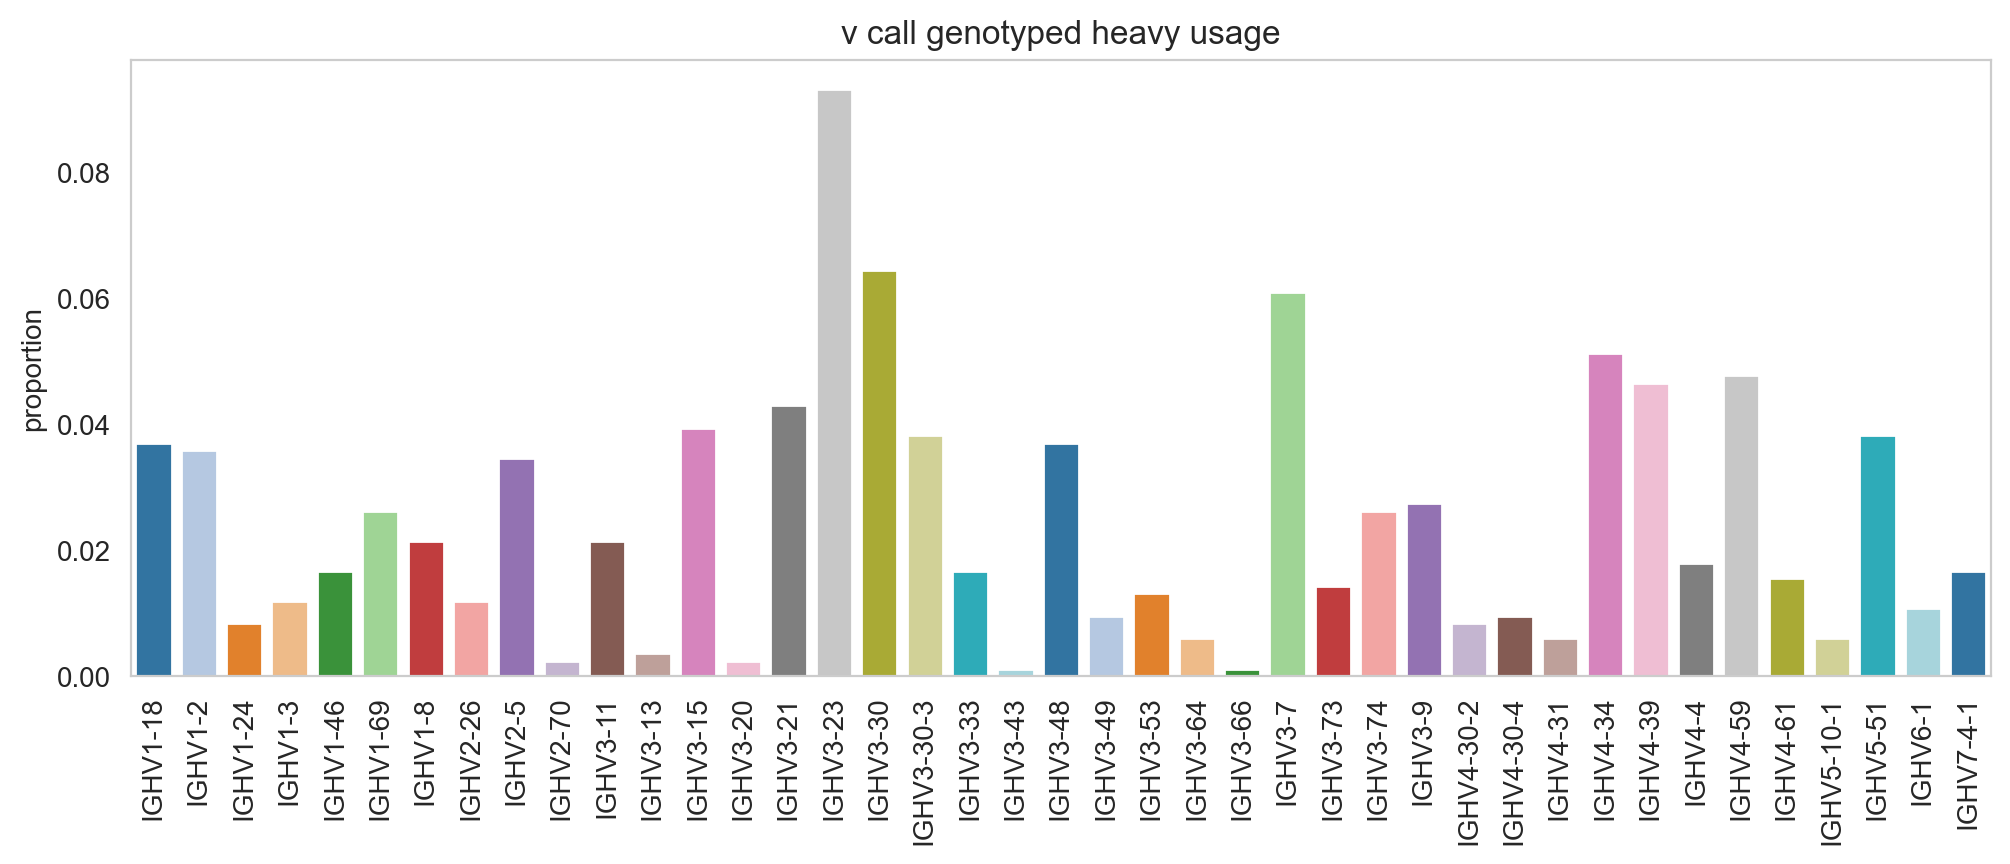

In [17]:
ddl.pl.barplot(vdj, variable = 'v_call_genotyped_heavy', figsize = (12, 4), sort_descending = None, palette = 'tab20')

Specifying `normalize = False` will change the y-axis to counts.

(<Figure size 1200x400 with 1 Axes>,
 <AxesSubplot:title={'center':'v call genotyped heavy usage'}, ylabel='count'>)

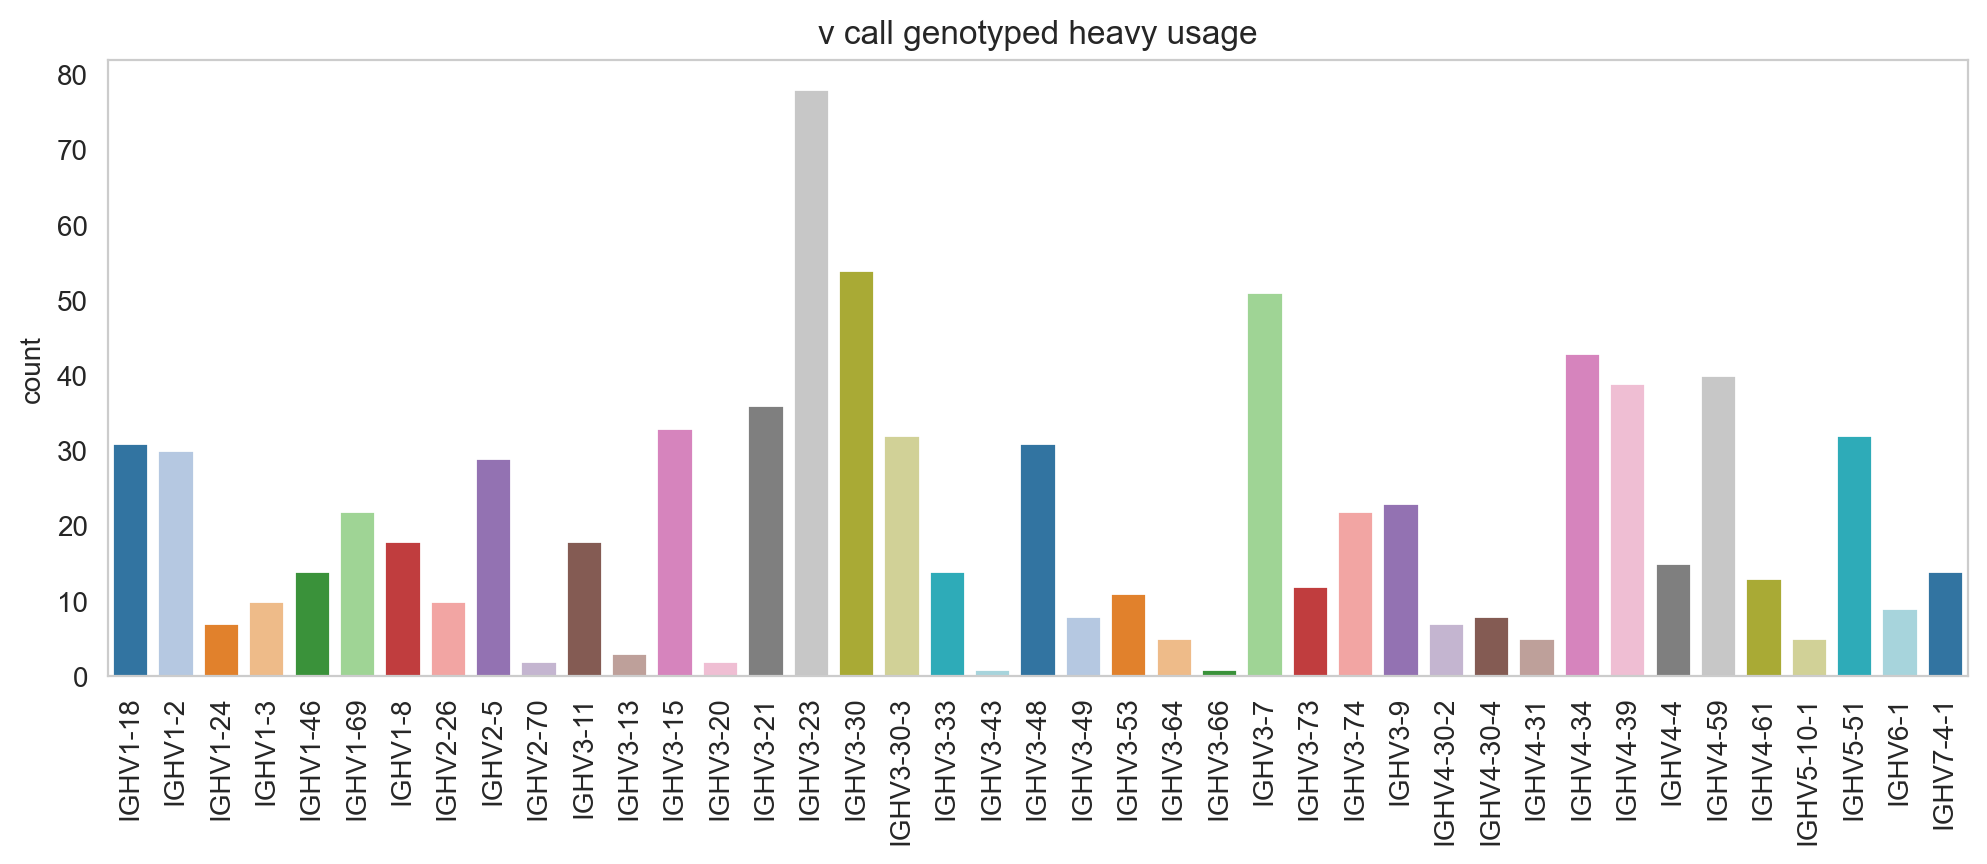

In [18]:
ddl.pl.barplot(vdj, variable = 'v_call_genotyped_heavy', normalize = False, figsize = (12, 4), sort_descending = None, palette = 'tab20')

### `pl.stackedbarplot`
`pl.stackedbarplot` is similar to above but can split between specified groups. Some examples below:

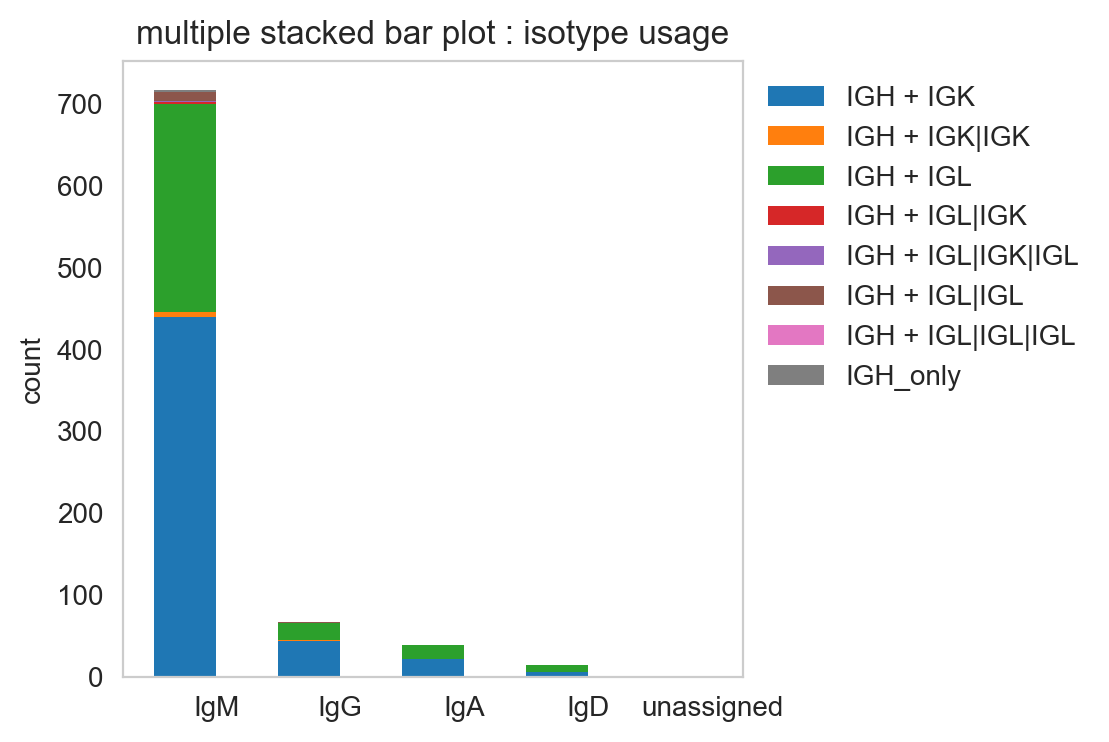

In [19]:
import matplotlib.pyplot as plt
ddl.pl.stackedbarplot(vdj, variable = 'isotype', groupby = 'status', xtick_rotation =0, figsize = (4,4))
plt.legend(bbox_to_anchor = (1,1), loc='upper left', frameon=False)

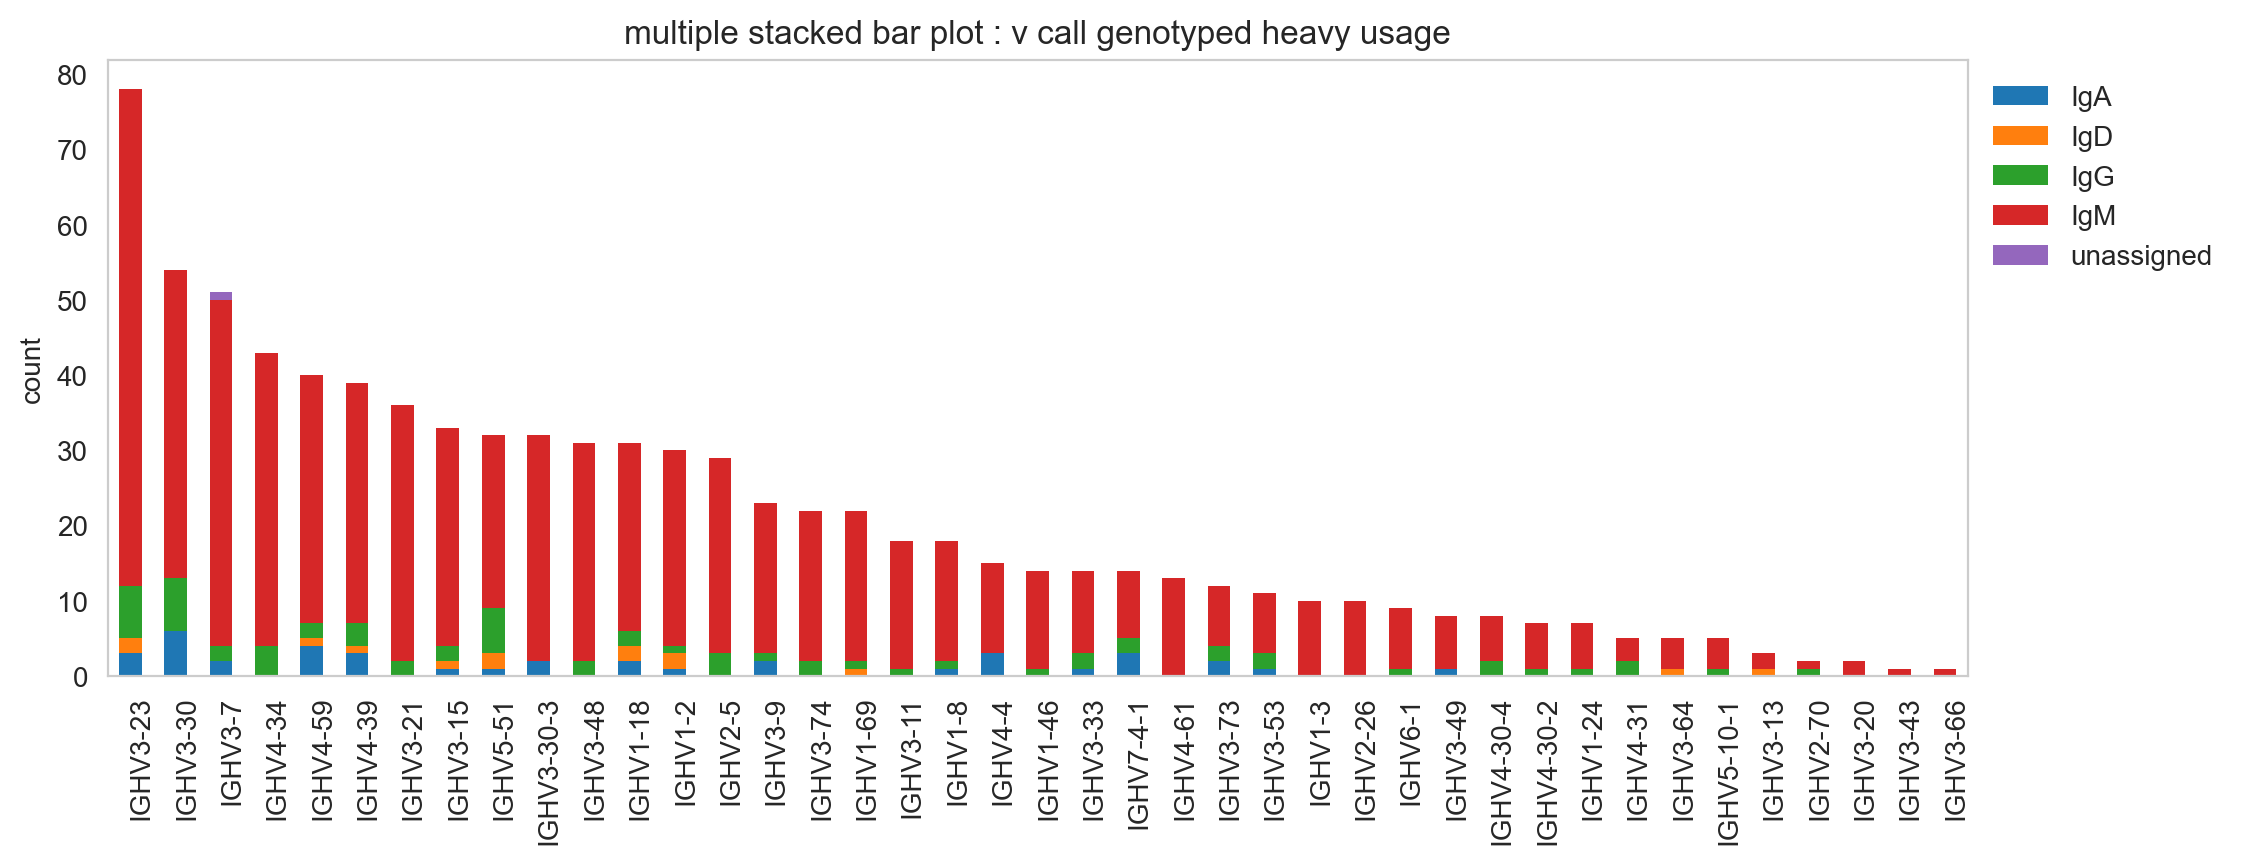

In [20]:
ddl.pl.stackedbarplot(vdj, variable = 'v_call_genotyped_heavy', groupby = 'isotype')
plt.legend(bbox_to_anchor = (1,1), loc='upper left', frameon=False)

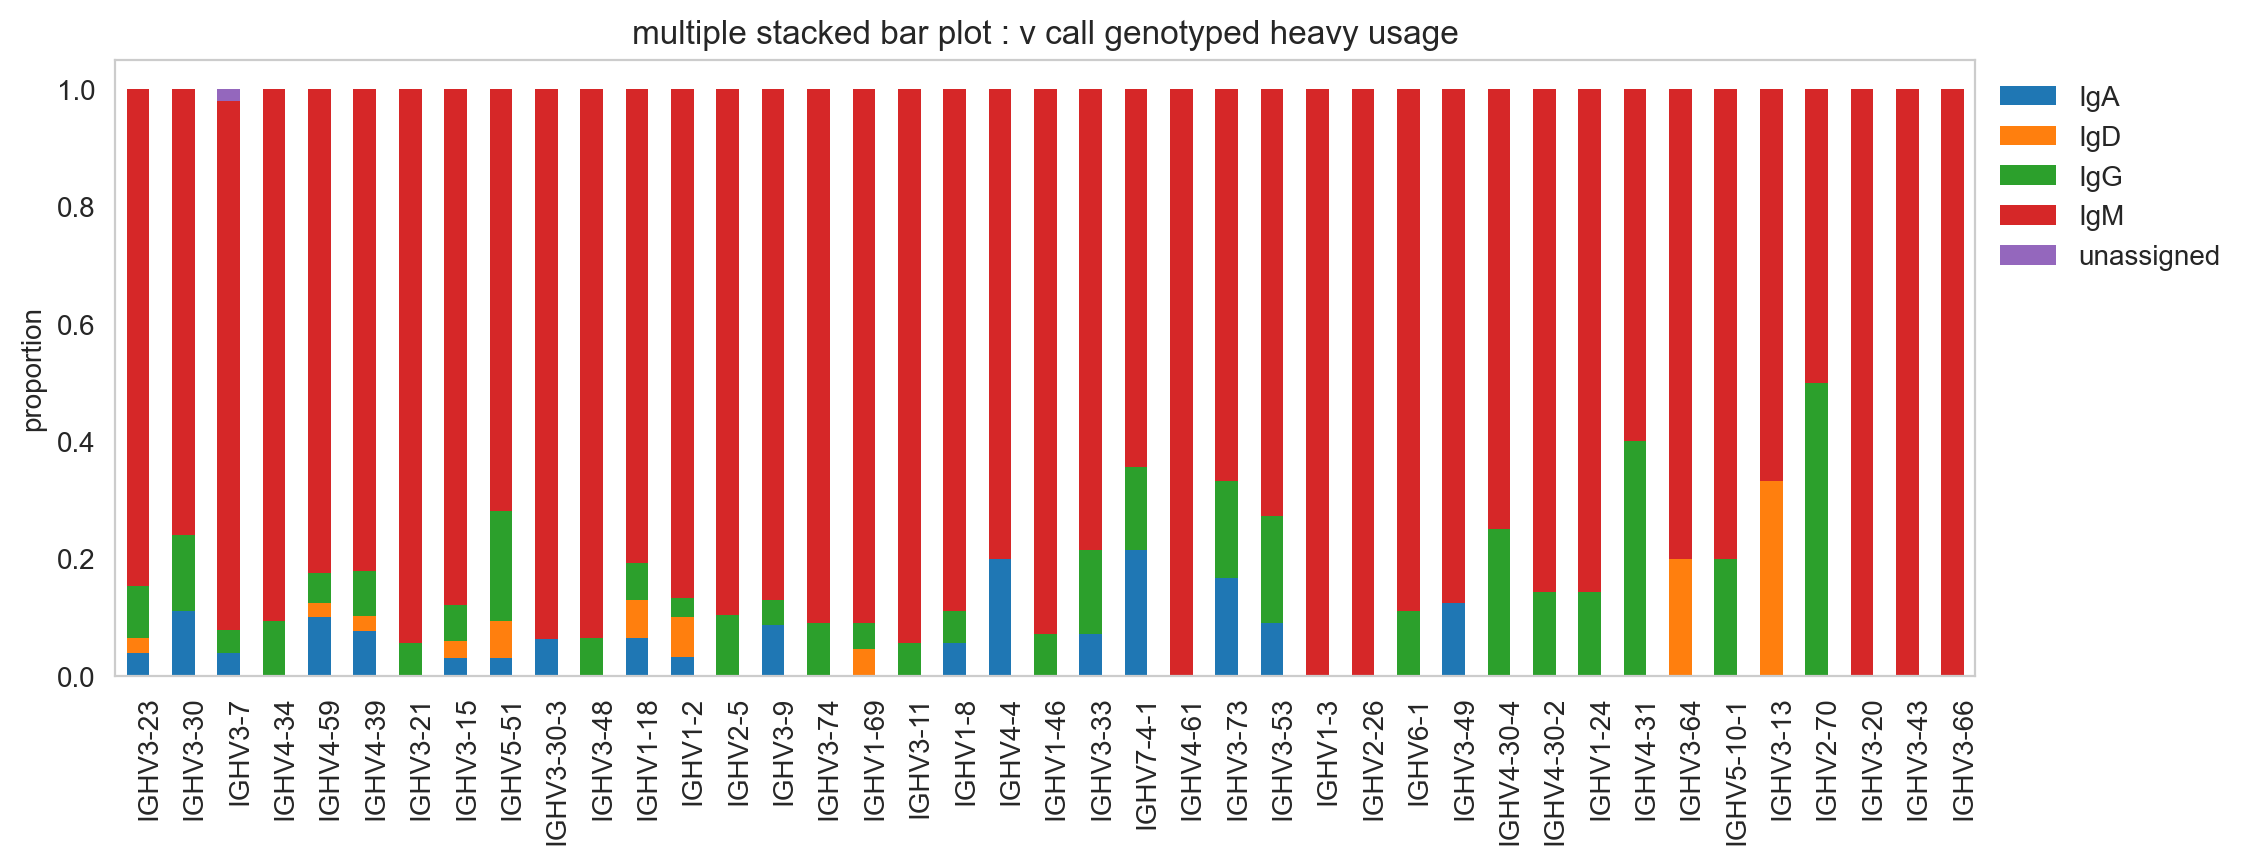

In [21]:
ddl.pl.stackedbarplot(vdj, variable = 'v_call_genotyped_heavy', groupby = 'isotype', normalize = True)
plt.legend(bbox_to_anchor = (1,1), loc='upper left', frameon=False)

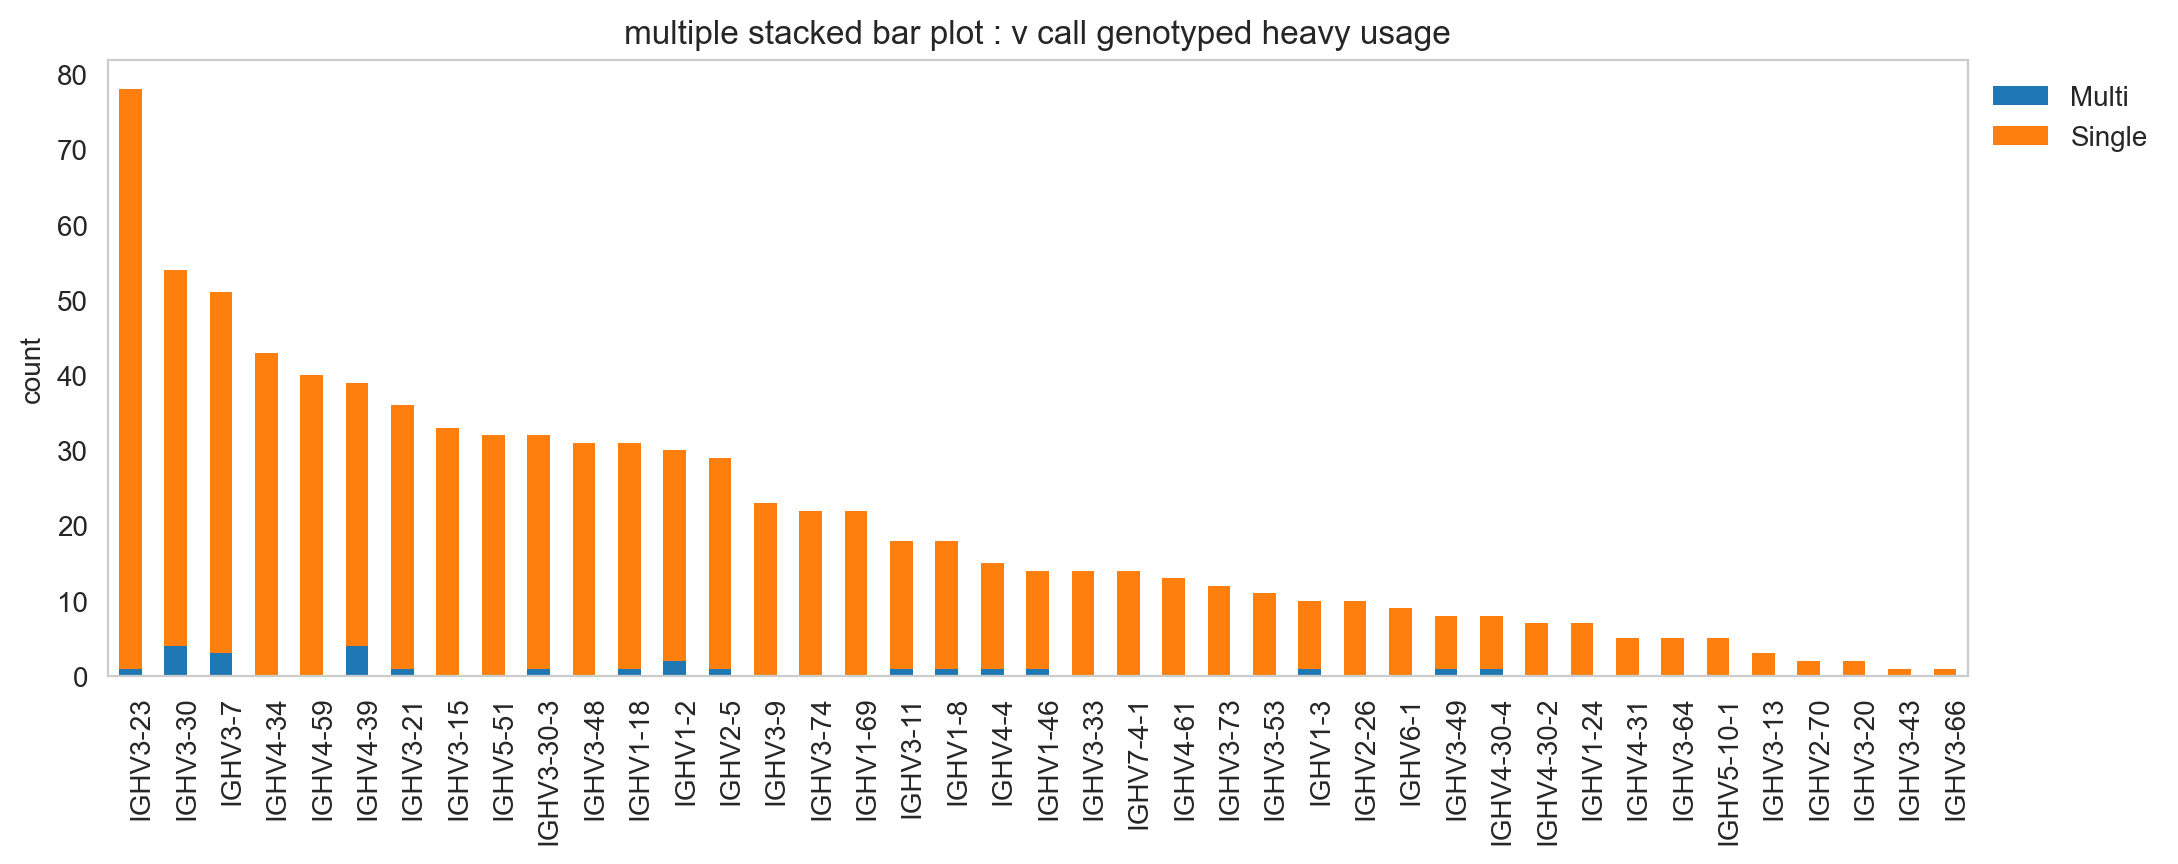

In [22]:
ddl.pl.stackedbarplot(vdj, variable = 'v_call_genotyped_heavy', groupby = 'vdj_status')
plt.legend(bbox_to_anchor = (1,1), loc='upper left', frameon=False)

It's obviously more useful if you don't have too many groups, but you could try and plot everything and jiggle the legend options and color.

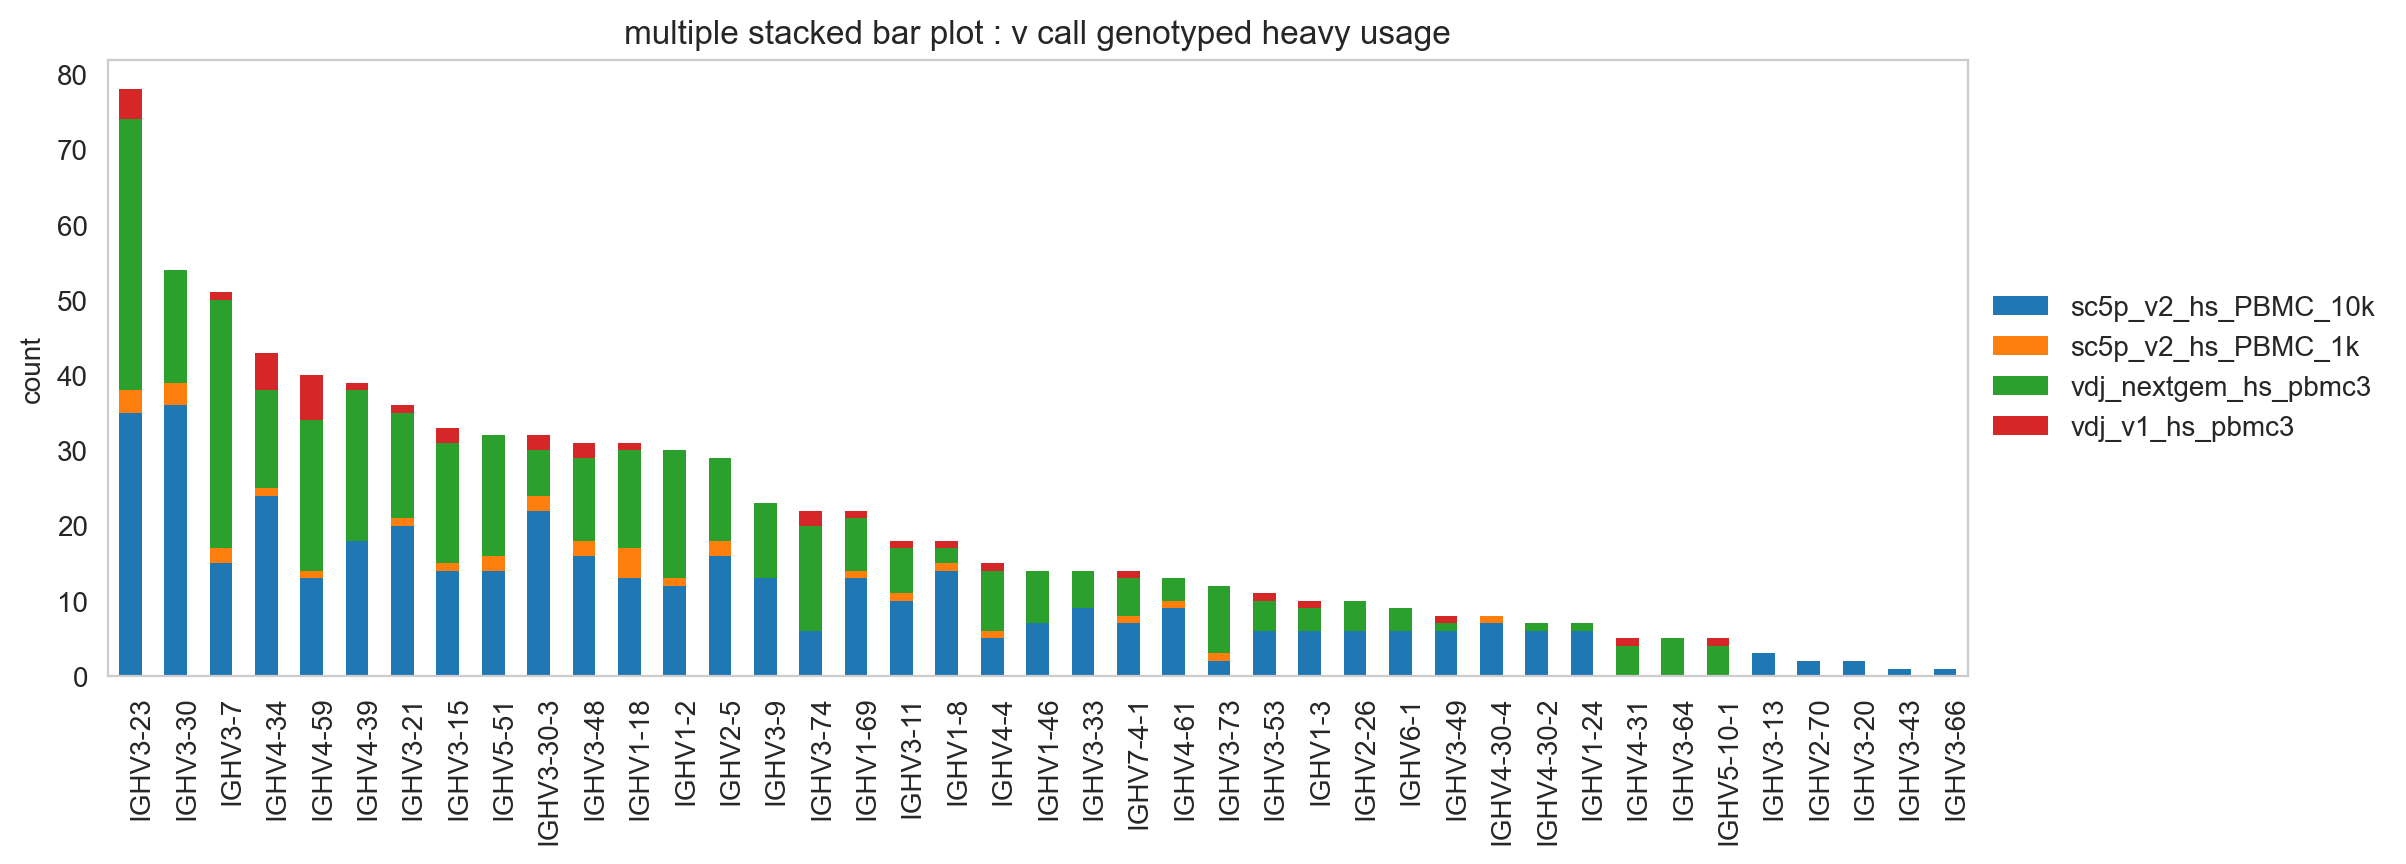

In [23]:
ddl.pl.stackedbarplot(vdj, variable = 'v_call_genotyped_heavy', groupby = 'sample_id')
plt.legend(bbox_to_anchor = (1, 0.5), loc='center left', frameon=False)

### `pl.spectratype`
Spectratype plots contain info displaying CDR3 length distribution for specified groups. For this function, the current method only works for `dandelion` objects as it requires access to the contig-indexed *.data* slot.

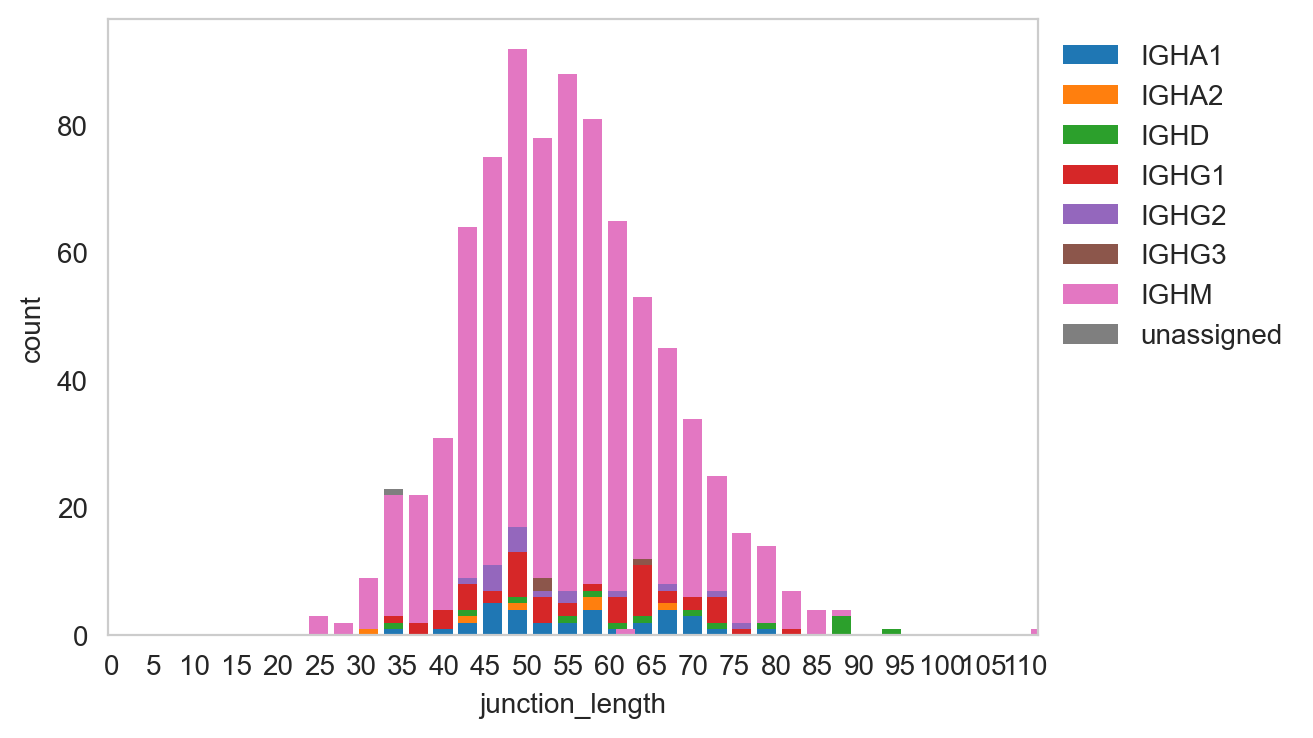

In [24]:
ddl.pl.spectratype(vdj, variable = 'junction_length', groupby = 'c_call', locus='IGH', width = 2.3)
plt.legend(bbox_to_anchor = (1,1), loc='upper left', frameon=False)

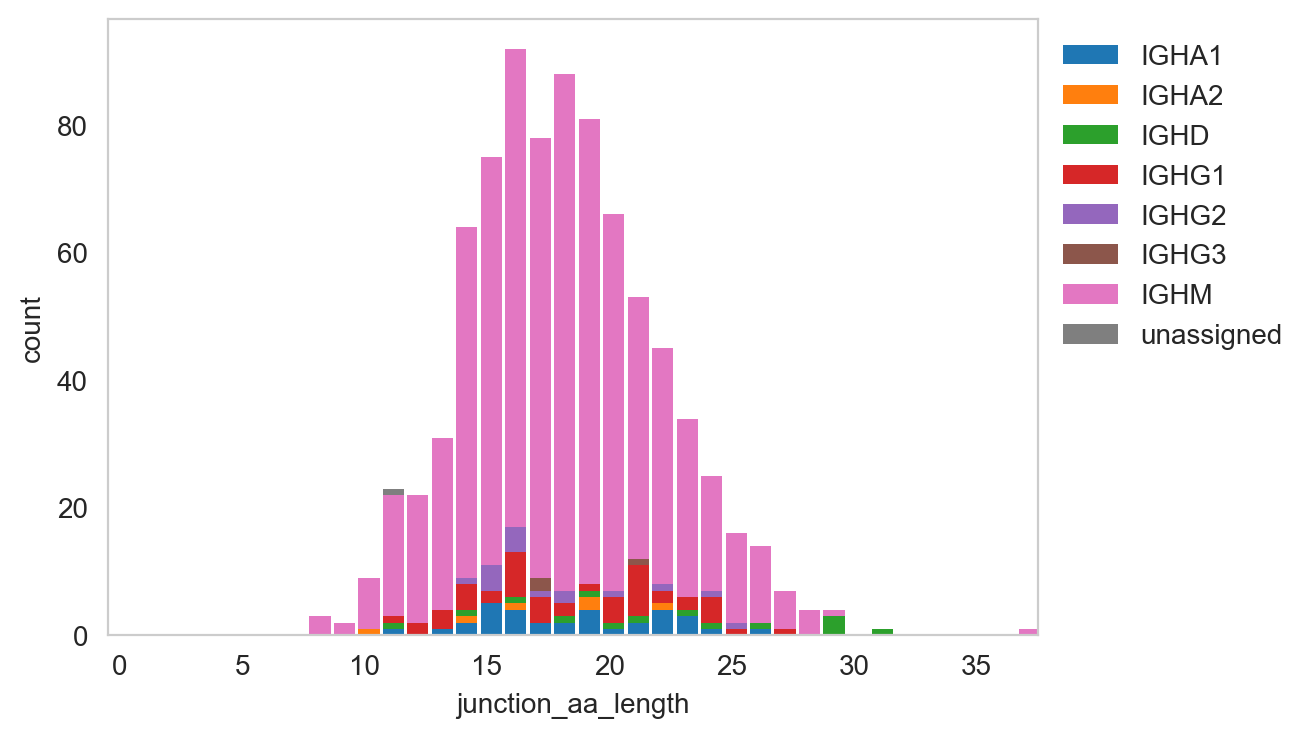

In [25]:
ddl.pl.spectratype(vdj, variable = 'junction_aa_length', groupby = 'c_call', locus='IGH')
plt.legend(bbox_to_anchor = (1,1), loc='upper left', frameon=False)

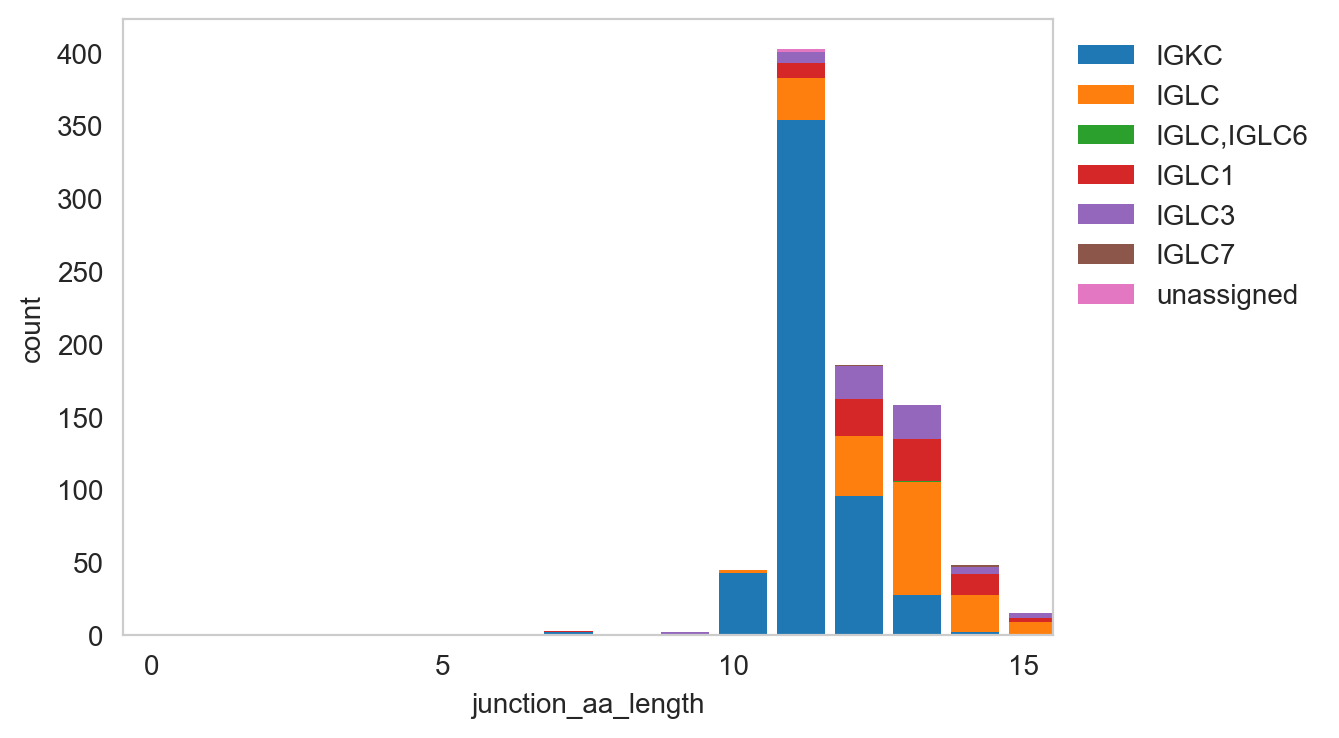

In [26]:
ddl.pl.spectratype(vdj, variable = 'junction_aa_length', groupby = 'c_call', locus=['IGK','IGL'])
plt.legend(bbox_to_anchor = (1,1), loc='upper left', frameon=False)

### `pl.clone_overlap`
There is now a circos-style clone overlap function where it looks for whather different samples share a clone. If they do, an arc/connection will be drawn between them. This requires the python module `nxviz` to be installed; at the writing of this notebook, there are some dependencies issues with `pip install nxviz`, therefore I've adjusted the requirements in a forked repository which you can install via: `pip install git+https://github.com/zktuong/nxviz.git`

In [27]:
ddl.tl.clone_overlap(adata, groupby = 'leiden', colorby = 'leiden')

Finding clones
 finished: Updated AnnData: 
   'uns', clone overlap table (0:00:00)


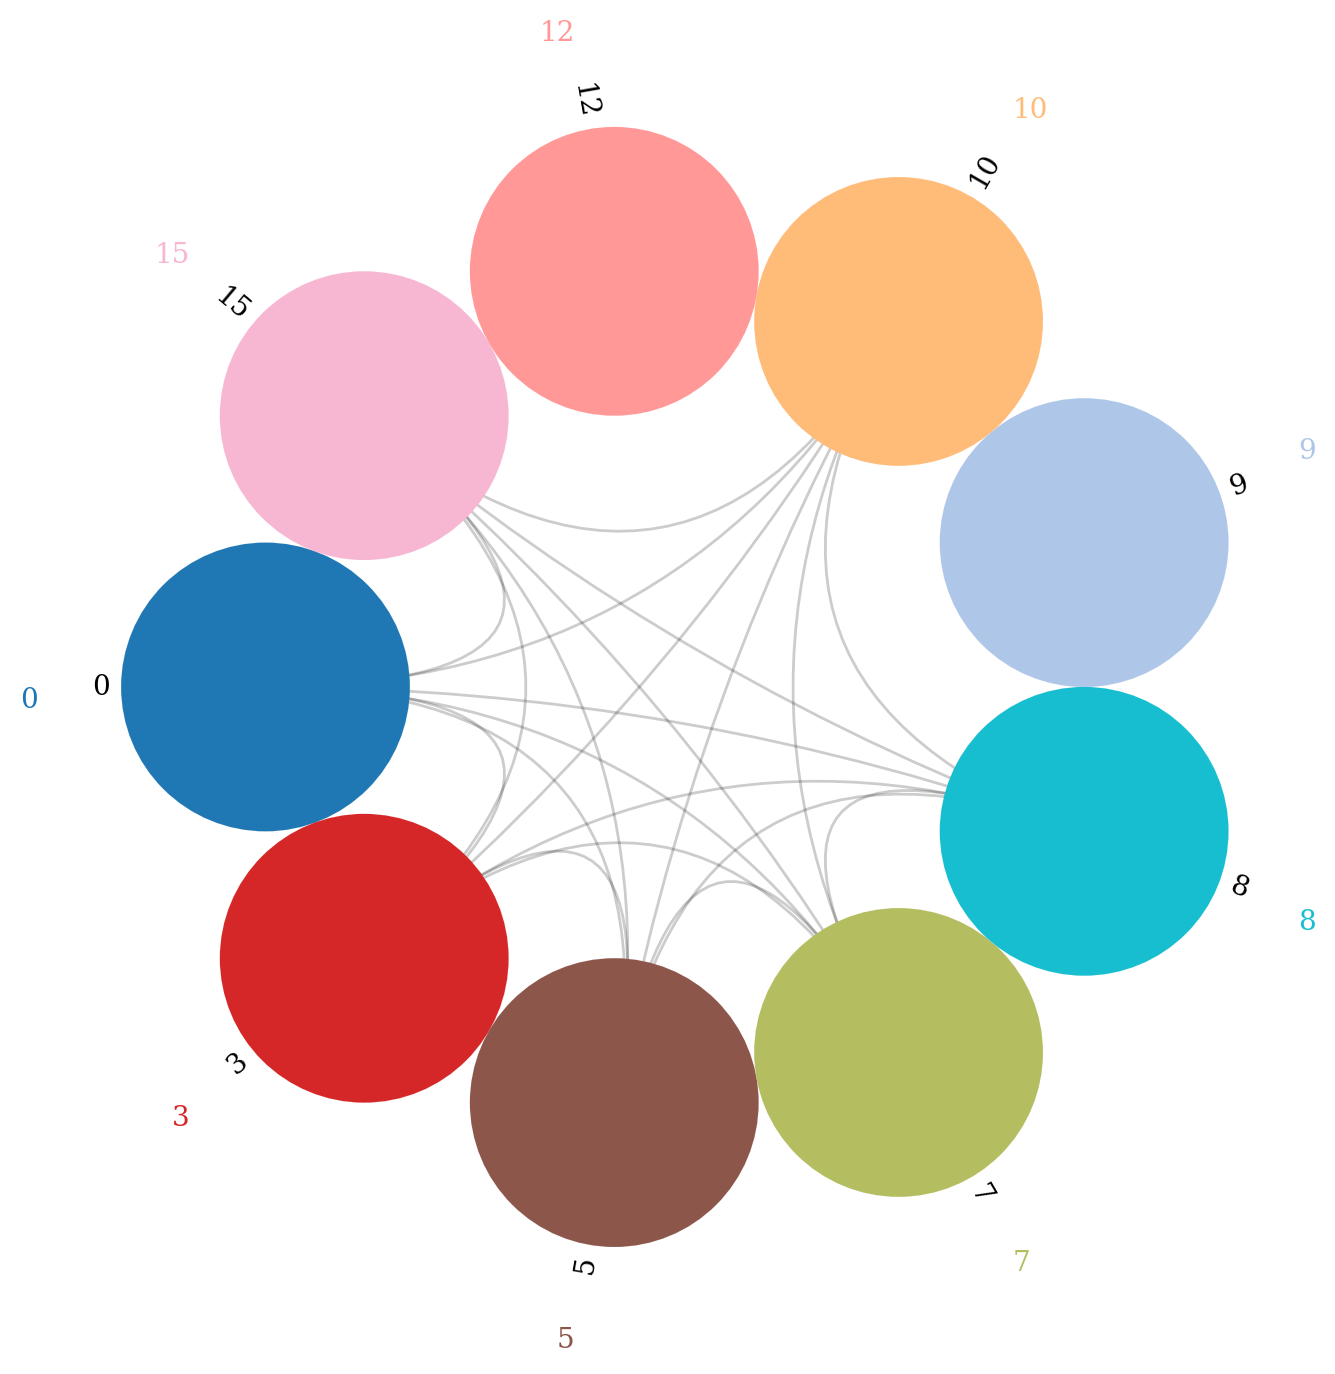

In [28]:
ddl.pl.clone_overlap(adata, groupby = 'leiden', colorby = 'leiden', return_graph=True, group_label_offset=.5)

Other use cases for this would be, for example, to plot nodes as individual samples and the colors as group classifications of the samples. As long as this information is found in the `.obs` column in the `AnnData`, or even `Dandelion.metadata`, this will work.